In [34]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *

In [ ]:
data_root = r"C:\Data\cosine\insilico_experiments\data\meta_data_files"
expriment_meta_data_df = pd.read_hdf(os.path.join(data_root, "meta_data_alexnet_most_fc6_conv5_4.h5"), key="expriment_meta_data_df")
expriment_meta_data_df.head(100)

In [35]:
#let firsth load the meta data dataframe
data_root = r"C:\Data\cosine\insilico_experiments\Most_active_vs_random\results\rotated2023-06-16_00-40"
save_root = r"C:\Data\cosine\insilico_experiments\Most_active_vs_random\results\posthock_rotation"
if not os.path.exists(save_root):
    os.makedirs(save_root)
expriment_meta_data_df = pd.read_hdf(os.path.join(data_root, "expriment_meta_data_df.h5"), key="expriment_meta_data_df")
expriment_meta_data_df.head()

,output_type,trget_imge_name,similarity_metric,pop_size,pop_resampling_id,gan_name,layer_name,layer_short,net_name,img_size,pading_size,input_size,score,pop_unit_idx,sub_pop_type,gen_rerun_id
1686890423_5444696,target_img,ILSVRC2012_val_00000013,None,16,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",NaN,"[10731, 12421, 14111, 17153, 18505, 20026, 228...",random,None
1686890423_3340520,target_img_RF_masked,ILSVRC2012_val_00000013,None,16,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",NaN,"[10731, 12421, 14111, 17153, 18505, 20026, 228...",random,None
1686890437_8050211,best_gen_imgs,ILSVRC2012_val_00000013,cosine,16,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",0.994461,"[10731, 12421, 14111, 17153, 18505, 20026, 228...",random,0
1686890437_3244256,best_gen_imgs_RF_masked,ILSVRC2012_val_00000013,cosine,16,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",0.994461,"[10731, 12421, 14111, 17153, 18505, 20026, 228...",random,0
1686890437_1343255,last_gen_mean_imgs,ILSVRC2012_val_00000013,cosine,16,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",0.968970,"[10731, 12421, 14111, 17153, 18505, 20026, 228...",random,0


In [ ]:
# loop over all rows of the meta data dataframe and if the output_type is "best_in_each_gen_imgs" load the image as tensor and the image with output_type as "output_type" and 
# similar trget_imge_name	similarity_metric	pop_size	pop_resampling_id	gan_name	layer_short	net_name	 
import glob
import shutil
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
import torch
import lpips

net="alex"
LPIPS_loss_fn = lpips.LPIPS(net=net)
expriment_meta_data_df_post_hock = expriment_meta_data_df.copy()
# add a new column to the dataframe to store the l2 distance between the generated image and the target image
expriment_meta_data_df_post_hock["l2_distance"] = np.nan
expriment_meta_data_df_post_hock["LPIPS_similarity"] = np.nan
# define a function to find the target image id
def find_target_image_id(data_table, row):
    # find the target row in the data_table dataframe that have similar similar:
    # trget_imge_name	similarity_metric	pop_size	pop_resampling_id	gan_name	layer_short	net_name but it has output_type as "target_img_RF_masked"
    if row["sub_pop_type"] == "random":

        target_row = data_table.loc[(data_table["trget_imge_name"] == row["trget_imge_name"]) & (
            data_table["pop_size"] == row["pop_size"]) & (data_table["pop_resampling_id"] == row["pop_resampling_id"]) & (data_table["gan_name"] == row["gan_name"]) & (
            data_table["layer_short"] == row["layer_short"]) & (data_table["net_name"] == row["net_name"]) & (data_table["output_type"] == "target_img_RF_masked") & (
            data_table["sub_pop_type"] == row["sub_pop_type"])]
    else:
        target_row = data_table.loc[(data_table["trget_imge_name"] == row["trget_imge_name"]) & (
            data_table["pop_size"] == row["pop_size"]) & (data_table["gan_name"] == row["gan_name"]) & (
            data_table["layer_short"] == row["layer_short"]) & (data_table["net_name"] == row["net_name"]) & (data_table["output_type"] == "target_img_RF_masked")& (
            data_table["sub_pop_type"] == row["sub_pop_type"])]
    if len(target_row) != 1:
        raise ValueError("The target row is not unique")
    return target_row.index[0]
# definne a function to calculate the l2 distance between two tensors
def l2_distance(tensor1, tensor2):
    return torch.sqrt(torch.sum((tensor1 - tensor2)**2))
def lpsips_distance(tensor1, tensor2, LPIPS_loss_fn):
    #convert the tensor from (3, 256, 256) to (1, 3, 256, 256)
    im0 = tensor1.unsqueeze(0)
    im1 = tensor2.unsqueeze(0)
    return LPIPS_loss_fn.forward(im0,im1)
# loop over all rows of the meta data dataframe
for i, row in expriment_meta_data_df.iterrows():
    if row["output_type"] == "best_gen_imgs_RF_masked":
        # load the image as tensor
        img_path = glob.glob(os.path.join(data_root, data_root, f"{i}.jpg"))[0]
        img = Image.open(img_path)
        gen_image_tensor = ToTensor()(img)
        # find target image id and load the image as tensor
        i_target = find_target_image_id(expriment_meta_data_df, row)
        # load the target image as tensor
        img_path = glob.glob(os.path.join(data_root, data_root, f"{i_target}.jpg"))[0]
        img = Image.open(img_path)
        target_image_tensor = ToTensor()(img)    
        # plot the generated image and the target image in a figure to make sure that they are the same
        '''fig, ax = plt.subplots(1, 2)
        ax[0].imshow(ToPILImage()(gen_image_tensor))
        ax[1].imshow(ToPILImage()(target_image_tensor))
        plt.show()'''
        # calculate the l2 distance between the generated image and the target image and store it in the dataframe
        expriment_meta_data_df_post_hock.loc[i, "l2_distance"] = l2_distance(gen_image_tensor, target_image_tensor).item()
        expriment_meta_data_df_post_hock.loc[i, "LPIPS_similarity"] = lpsips_distance(gen_image_tensor, target_image_tensor, LPIPS_loss_fn).item()
        

In [ ]:
# load the dataframe that saved in the previous step
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *

if not os.path.exists(save_root):
    os.makedirs(save_root)
expriment_meta_data_df = pd.read_hdf(os.path.join(data_root, "expriment_meta_data_df.h5"), key="expriment_meta_data_df")
expriment_meta_data_df_post_hock = pd.read_hdf(os.path.join(save_root, "expriment_meta_data_df_post_hock.h5"), key="expriment_meta_data_df_post_hock")

In [ ]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
from core.utils.CNN_scorers import TorchScorer

expriment_meta_data_df_post_hock["similarty_score_by_CNN"] = np.nan

network_list = ['alexnet', 'vgg16', 'densenet169',
                'resnet50', 'resnet50_linf2', 'resnet101']
# make a dict of modek name and models scorer
scorer_dict = dict()
for net_name in network_list:
    scorer_dict[net_name] = TorchScorer(net_name)
    expriment_meta_data_df_post_hock[net_name] = np.nan

row_count = 0
for i, row in expriment_meta_data_df.iterrows():
    if row["output_type"] == "best_gen_imgs_RF_masked":
        if row_count % 100 == 0:
            print(f"row count that get done: {row_count}")
        # load the image as tensor
        img_path = glob.glob(os.path.join(data_root, data_root, f"{i}.jpg"))[0]
        img = Image.open(img_path)
        gen_image_tensor = ToTensor()(img)
        # find target image id and load the image as tensor
        i_target = find_target_image_id(expriment_meta_data_df, row)
        # load the target image as tensor
        img_path = glob.glob(os.path.join(data_root, data_root, f"{i_target}.jpg"))[0]
        img = Image.open(img_path)
        target_image_tensor = ToTensor()(img)    
        # calculate the l2 distance between the generated image and the target image and store it in the dataframe
        get_similarty_score_by_CNN(gen_image_tensor, target_image_tensor, scorer_dict, expriment_meta_data_df_post_hock, i)
        row_count += 1

# save the dataframe
expriment_meta_data_df_post_hock.to_hdf(os.path.join(save_root, "expriment_meta_data_df_post_hock.h5"), key="expriment_meta_data_df_post_hock", mode="w")


In [ ]:
expriment_meta_data_df_post_hock.head()

In [ ]:
metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "l2_distance" # "LPIPS_similarity"
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
i = 0
jetring_val = 1.1
for metric_name in metric_name_list:
    ''''
    sub_pop_type = "most"
    
    mean_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby("pop_size")[perceptual_similarity].mean()

    std_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby("pop_size")[perceptual_similarity].sem()


    mean_result_index_most = mean_result_most.index
    mean_result_most = mean_result_most.values
    std_result_most = std_result_most.values

    sub_pop_type = "random"
    mean_result_random = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby("pop_size")[perceptual_similarity].mean()
    std_result_random  = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby("pop_size")[perceptual_similarity].sem()
    mean_result_index_random  = mean_result_random.index
    mean_result_random  = mean_result_random.values
    std_result_random = std_result_random.values
    '''
    sub_pop_type = "most"
    mean_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].mean()
    std_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].sem()

    mean_result_index_most = mean_result_most.index
    mean_result_most = mean_result_most.values
    std_result_most = std_result_most.values

    sub_pop_type = "random"
    mean_result_random =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].mean()
    std_result_random  = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].sem()
    mean_result_index_random  = mean_result_random.index
    mean_result_random  = mean_result_random.values
    std_result_random = std_result_random.values

    # remove the first element from the random sampling and the most active units if the metric is COSINE similarity
    if metric_name == "cosine":
        mean_result_index_random = mean_result_index_random[1:]
        mean_result_random = mean_result_random[1:]
        std_result_random = std_result_random[1:]
        mean_result_index_most = mean_result_index_most[1:]
        mean_result_most = mean_result_most[1:]
        std_result_most = std_result_most[1:]
    # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
    ax[i].errorbar(mean_result_index_random, mean_result_random, yerr=std_result_random, fmt='o-', color='blue', ecolor='lightblue', elinewidth=3, capsize=0)
    ax[i].errorbar(mean_result_index_most*jetring_val, mean_result_most, yerr=std_result_most, fmt='o-', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
    ax[i].set_xscale('log', base=2)
    ax[i].set_xlabel("Population size")
    if perceptual_similarity == 'l2_distance':
        ax[i].set_ylabel(f"l2 distance")
    else:
        ax[i].set_ylabel(f"perceptual similarity \n {perceptual_similarity}")
    ax[i].set_title(f"Similarity metric: {metric_name}", fontsize=17)
    ax[i].legend(["random sampling", "most active units"], fontsize=15)
 # increa the font size of the x and y axis labels
    ax[i].xaxis.label.set_size(17)
    ax[i].yaxis.label.set_size(17)
    # chabge the font size of the x and y ticks
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    i += 1
# get y lims for all the subplots
y_lims = [ax[i].get_ylim() for i in range(len(ax))]
# define the y lim that cincludes all the subplots y lims
y_lim = [min([y_lims[i][0] for i in range(len(ax))]), max([y_lims[i][1] for i in range(len(ax))])]
# set the y lim for all the subplots
for i in range(len(ax)):
    ax[i].set_ylim(y_lim)
plt.show()

# SAVE THE FIGURE IN THE RESULTS FOLDER
curent_result_folder = os.path.join(save_root, "perceptual_similarity_vs_pop_size")
if not os.path.exists(curent_result_folder):
    os.makedirs(curent_result_folder)
fig.savefig(os.path.join(curent_result_folder, f"{perceptual_similarity}_vs_pop_size.png"), bbox_inches='tight')


In [ ]:
# let plot each population resmapleing seperatly to have fair comparison between the two methods
resampling_ids = expriment_meta_data_df_post_hock["pop_resampling_id"].unique()
resampling_ids = resampling_ids[~pd.isnull(resampling_ids)]
metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "alexnet" # "LPIPS_similarity"
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
i = 0
jetring_val = 1.15
for metric_name in metric_name_list:
    sub_pop_type = "most"
    mean_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].mean()
    std_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].sem()

    mean_result_index_most = mean_result_most.index
    mean_result_most = mean_result_most.values
    std_result_most = std_result_most.values

    # remove the first element from the random sampling and the most active units if the metric is COSINE similarity
    if metric_name == "cosine":
        mean_result_index_most = mean_result_index_most[1:]
        mean_result_most = mean_result_most[1:]
        std_result_most = std_result_most[1:]

    # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
    ax[i].errorbar(mean_result_index_most*jetring_val, mean_result_most, yerr=std_result_most, fmt='o-', color='black', ecolor='gray', elinewidth=3, capsize=0)

    sub_pop_type = "random"
    for resampling_id in resampling_ids:
        #generating a random color between 1.1 and 1.2
        jetering_val = np.random.uniform(1, 1.3)
        mean_result_random =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["pop_resampling_id"] == resampling_id) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].mean()
        std_result_random  = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["pop_resampling_id"] == resampling_id) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].sem()

        mean_result_index_random  = mean_result_random.index
        mean_result_random  = mean_result_random.values
        std_result_random = std_result_random.values
        # remove the first element from the random sampling and the most active units if the metric is COSINE similarity
        if metric_name == "cosine":
            mean_result_index_random = mean_result_index_random[1:]
            mean_result_random = mean_result_random[1:]
            std_result_random = std_result_random[1:]
        # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
        ax[i].errorbar(mean_result_index_random*jetering_val, mean_result_random, yerr=std_result_random, fmt='o-', color='blue', ecolor='lightblue', elinewidth=3, capsize=0, alpha=0.25)
    
    ax[i].set_xscale('log', base=2)
    ax[i].set_xlabel("Population size")
    ax[i].set_ylabel(perceptual_similarity + " last layer corolation")
    ax[i].set_title(f"Similarity metric: {metric_name}", fontsize=17)
    #ax[i].legend(["random sampling", "most active units"], fontsize=15)
 # increa the font size of the x and y axis labels
    ax[i].xaxis.label.set_size(17)
    ax[i].yaxis.label.set_size(17)
    # chabge the font size of the x and y ticks
    ax[i].tick_params(axis='both', which='major', labelsize=15)

    i += 1
plt.show()

# SAVE THE FIGURE IN THE RESULTS FOLDER
fig.savefig(os.path.join(save_root, f"{perceptual_similarity}_vs_pop_size_line_for_pop_resampling.png"), bbox_inches='tight')


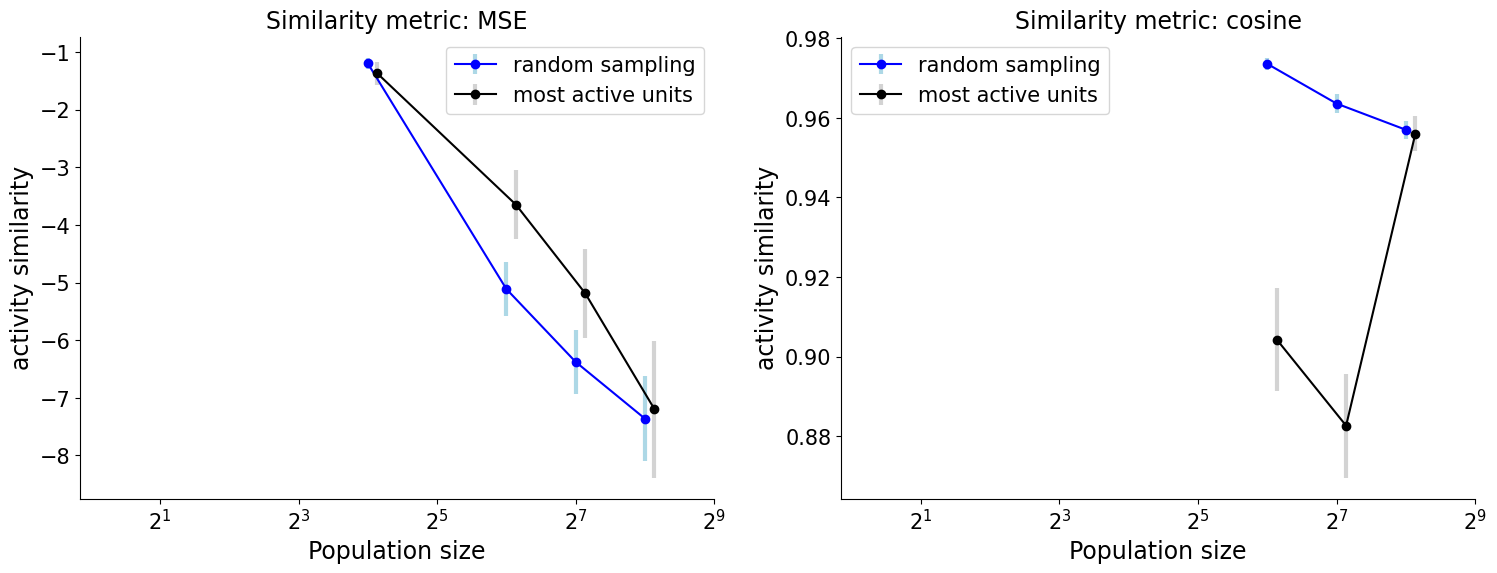

In [36]:
metric_name_list = ["MSE", "cosine"]
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
i = 0
jetring_val = 1.1
for metric_name in metric_name_list:

    sub_pop_type = "most"
    mean_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])["score"].mean().reset_index().groupby(
                                                        "pop_size")["score"].mean()
    std_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])["score"].mean().reset_index().groupby(
                                                        "pop_size")["score"].sem()

    mean_result_index_most = mean_result_most.index
    mean_result_most = mean_result_most.values
    std_result_most = std_result_most.values

    sub_pop_type = "random"
    mean_result_random =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size", "pop_resampling_id"])["score"].mean().reset_index().groupby(
                                                        "pop_size")["score"].mean()
    std_result_random  = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size", "pop_resampling_id"])["score"].mean().reset_index().groupby(
                                                        "pop_size")["score"].sem()
    mean_result_index_random  = mean_result_random.index
    mean_result_random  = mean_result_random.values
    std_result_random = std_result_random.values
    

    # remove the first element from the random sampling and the most active units if the metric is COSINE similarity
    if metric_name == "cosine":
        mean_result_index_random = mean_result_index_random[1:]
        mean_result_random = mean_result_random[1:]
        std_result_random = std_result_random[1:]
        mean_result_index_most = mean_result_index_most[1:]
        mean_result_most = mean_result_most[1:]
        std_result_most = std_result_most[1:]
    # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis
    
    ax[i].errorbar(mean_result_index_random, mean_result_random, yerr=std_result_random, fmt='o-', color='blue', ecolor='lightblue', elinewidth=3, capsize=0)
    ax[i].errorbar(mean_result_index_most*jetring_val, mean_result_most, yerr=std_result_most, fmt='o-', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
    ax[i].set_xscale('log', base=2)
    ax[i].set_xlabel("Population size")
    ax[i].set_ylabel("activity similarity")
    ax[i].set_title(f"Similarity metric: {metric_name}", fontsize=17)
    ax[i].legend(["random sampling", "most active units"], fontsize=15)
 # increa the font size of the x and y axis labels
    ax[i].xaxis.label.set_size(17)
    ax[i].yaxis.label.set_size(17)
    # chabge the font size of the x and y ticks
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].set_xlim([.9, 2**9])
    i += 1
plt.show()

# SAVE THE FIGURE IN THE RESULTS FOLDER
fig.savefig(os.path.join(save_root, "acivity_similarty_vs_pop_size.png"), bbox_inches='tight')

In [ ]:
# let plot each population resmapleing seperatly to have fair comparison between the two methods
metric_name_list = ["MSE", "cosine"]
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
i = 0
jetring_val = 1.15
for metric_name in metric_name_list:
    sub_pop_type = "most"
    mean_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])["score"].mean().reset_index().groupby(
                                                        "pop_size")["score"].mean()
    std_result_most = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])["score"].mean().reset_index().groupby(
                                                        "pop_size")["score"].sem()

    mean_result_index_most = mean_result_most.index
    mean_result_most = mean_result_most.values
    std_result_most = std_result_most.values

    # remove the first element from the random sampling and the most active units if the metric is COSINE similarity
    if metric_name == "cosine":
        mean_result_index_most = mean_result_index_most[1:]
        mean_result_most = mean_result_most[1:]
        std_result_most = std_result_most[1:]
    # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis
    
    ax[i].errorbar(mean_result_index_most*jetring_val, mean_result_most, yerr=std_result_most, fmt='o-', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

    sub_pop_type = "random"
    for resampling_id in resampling_ids:
        #generating a random color between 1.1 and 1.2
        jetering_val = np.random.uniform(1, 1.3)
        mean_result_random =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["pop_resampling_id"] == resampling_id) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size", "pop_resampling_id"])["score"].mean().reset_index().groupby(
                                                            "pop_size")["score"].mean()
        std_result_random  = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["pop_resampling_id"] == resampling_id) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size", "pop_resampling_id"])["score"].mean().reset_index().groupby(
                                                            "pop_size")["score"].sem()
        mean_result_index_random  = mean_result_random.index
        mean_result_random  = mean_result_random.values
        std_result_random = std_result_random.values
        # remove the first element from the random sampling and the most active units if the metric is COSINE similarity
        if metric_name == "cosine":
            mean_result_index_random = mean_result_index_random[1:]
            mean_result_random = mean_result_random[1:]
            std_result_random = std_result_random[1:]
        # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
        ax[i].errorbar(mean_result_index_random*jetering_val, mean_result_random, yerr=std_result_random, fmt='o-', color='blue', ecolor='lightblue', elinewidth=3, capsize=0, alpha=0.25)

    ax[i].set_xscale('log', base=2)
    ax[i].set_xlabel("Population size")
    ax[i].set_ylabel("activity similarity")
    ax[i].set_title(f"Similarity metric: {metric_name}", fontsize=17)
    #ax[i].legend(["random sampling", "most active units"], fontsize=15)
    # increa the font size of the x and y axis labels
    ax[i].xaxis.label.set_size(17)
    ax[i].yaxis.label.set_size(17)
    # chabge the font size of the x and y ticks
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    
    ax[i].set_xlim([.9, 2**9])
    i += 1
plt.show()

# SAVE THE FIGURE IN THE RESULTS FOLDER
fig.savefig(os.path.join(save_root, "acivity_similarty_vs_pop_size_line_for_pop_resampling.png"), bbox_inches='tight')

In [ ]:
# plot the images in a grid: the rows will be "target_img_RF_masked", "best_gen_imgs_RF_masked" (for diffrent resampling id) and the columns will be the diffrent population sizesax  
num_of_popilation_sizes = len(expriment_meta_data_df_post_hock["pop_size"].unique())
resampling_ids = expriment_meta_data_df_post_hock["pop_resampling_id"].unique()
# remove the None value from the resampling ids
resampling_ids = resampling_ids[~pd.isnull(resampling_ids)]
num_of_resampling_ids = len(resampling_ids)
metric_name = "MSE"
trget_imge_names = expriment_meta_data_df_post_hock["trget_imge_name"].unique()
gen_rerun_id = 0
pop_resampling_id = 0
fig, ax = plt.subplots(2+num_of_resampling_ids, num_of_popilation_sizes, figsize=(17, 15))


def load_image_tsr(**kwargs):
     # find the row in the dataframe that match the input kwargs, the colums which are not mentioned in the kwargs are None
    img_row = expriment_meta_data_df_post_hock.loc[(expriment_meta_data_df_post_hock[list(kwargs)] == pd.Series(kwargs)).all(axis=1)]
    # if the row is empty return None
    if len(img_row) != 1:
             raise ValueError(f"the input kwargs: {kwargs} does not match any row in the dataframe or match more than one row")
    # if the row is not empty load the image
    else:
            img_path = glob.glob(os.path.join(data_root, data_root, f"{img_row.index[0]}.jpg"))[0]
            img = Image.open(img_path)
            image_tensor = ToTensor()(img)
            return image_tensor

for target_img in trget_imge_names:
    fig, ax = plt.subplots(2+num_of_resampling_ids, num_of_popilation_sizes, figsize=(17, 15))
    i = 0
    for popsize in expriment_meta_data_df_post_hock["pop_size"].unique():
        # find the target image:
        target_image_tensor = load_image_tsr(output_type="target_img_RF_masked", trget_imge_name=target_img, pop_size=popsize, sub_pop_type="most")
        # plot the target image
        ax[0, i].imshow(ToPILImage()(target_image_tensor))
        ax[0, i].set_title(f"pop size: {popsize}")
        ax[0, i].axis('off')

        # find the last gen image with most active sampling"
        best_gen_imgs_RF_masked_random = load_image_tsr(
                    output_type="best_gen_imgs_RF_masked", trget_imge_name=target_img, pop_size=popsize, sub_pop_type="most",
                    gen_rerun_id=gen_rerun_id, similarity_metric = metric_name)
        # add a frame to the image
        # best_gen_imgs_RF_masked_random = add_frame_by_score(best_gen_imgs_RF_masked_random, pad=10, score=0.5)
        # plot the target image
        ax[1, i].imshow(ToPILImage()(best_gen_imgs_RF_masked_random))
        ax[1, i].axis('off')
        # loop over all resampling ids
        for resampling_id in resampling_ids:
            # find the last gen image with random sampling"
            best_gen_imgs_RF_masked_random = load_image_tsr(
                    output_type="best_gen_imgs_RF_masked", trget_imge_name=target_img, pop_size=popsize, sub_pop_type="random",
                    pop_resampling_id= resampling_id, gen_rerun_id=gen_rerun_id, similarity_metric = metric_name)
            # plot the generated image
            ax[2+resampling_id, i].imshow(ToPILImage()(best_gen_imgs_RF_masked_random))
            #remove the axis
            ax[2+resampling_id, i].axis('off')
        i += 1
    plt.tight_layout()
    # save the figure
    # make a folder for the target image
    target_img_folder = os.path.join(save_root, f"target_img_{target_img}")
    if not os.path.exists(target_img_folder):
        os.mkdir(target_img_folder)

    plt.savefig(os.path.join(target_img_folder, f"target_img_{target_img}_{metric_name}_{gen_rerun_id}.png"))
    plt.show()
    plt.close()
    
        
    print(f"saved target_img_{target_img}_{metric_name}_{gen_rerun_id}.png")

        


In [ ]:
# set color scheme for the 0 t0 1 range
color = cmap((score - vmin) / (vmax - vmin))
# add a frame around the image mauanlly
img[:, 0:pad, :] = color[:3]
img[:, -pad:, :] = color[:3]
img[:, :, 0:pad] = color[:3]
img[:, :, -pad:] = color[:3]
return img



In [ ]:
# plot the images in a grid: the rows will be "target_img_RF_masked", "best_gen_imgs_RF_masked" (for diffrent resampling id) and the columns will be the diffrent population sizesax  
num_of_popilation_sizes = len(expriment_meta_data_df_post_hock["pop_size"].unique())
resampling_ids = expriment_meta_data_df_post_hock["pop_resampling_id"].unique()
gen_reruns = expriment_meta_data_df_post_hock["gen_rerun_id"].unique()
trget_imge_names = expriment_meta_data_df_post_hock["trget_imge_name"].unique()

# remove the None value from the resampling ids
gen_reruns = gen_reruns[~pd.isnull(gen_reruns)]
resampling_ids = resampling_ids[~pd.isnull(resampling_ids)]
num_of_resampling_ids = len(resampling_ids)
num_of_gen_reruns = len(gen_reruns)
metric_name = "MSE"
gen_rerun_id = 0
pop_resampling_id = 0

def load_image_tsr(**kwargs):
     # find the row in the dataframe that match the input kwargs, the colums which are not mentioned in the kwargs are None
    img_row = expriment_meta_data_df_post_hock.loc[(expriment_meta_data_df_post_hock[list(kwargs)] == pd.Series(kwargs)).all(axis=1)]
    # if the row is empty return None
    if len(img_row) != 1:
             raise ValueError(f"the input kwargs: {kwargs} does not match any row in the dataframe or match more than one row")
    # if the row is not empty load the image
    else:
            img_path = glob.glob(os.path.join(data_root, data_root, f"{img_row.index[0]}.jpg"))[0]
            img = Image.open(img_path)
            image_tensor = ToTensor()(img)
            return image_tensor
for trget_imge_name in trget_imge_names:
    fig, ax = plt.subplots(2+num_of_resampling_ids, num_of_popilation_sizes, figsize=(17, 15))
    i = 0
    for popsize in expriment_meta_data_df_post_hock["pop_size"].unique():
        # find the target image:
        target_image_tensor = load_image_tsr(output_type="target_img_RF_masked", trget_imge_name=trget_imge_name, pop_size=popsize, sub_pop_type="most")
        # plot the target image
        ax[0, i].imshow(ToPILImage()(target_image_tensor))
        ax[0, i].set_title(f"pop size: {popsize}")
        ax[0, i].axis('off')

        # find the last gen image with most active sampling"
        # load all the imageovwr regeneration runs
        best_gen_imgs_RF_masked_most_list = list()
        for gen_rerun_id in range(num_of_gen_reruns):
            best_gen_imgs_RF_masked_most_list.append(load_image_tsr(
                    output_type="best_gen_imgs_RF_masked", trget_imge_name=trget_imge_name, pop_size=popsize, sub_pop_type="most",
                    gen_rerun_id=gen_rerun_id, similarity_metric = metric_name))
        best_gen_imgs_RF_masked_most_mean = torch.stack(best_gen_imgs_RF_masked_most_list).mean(dim=0)
        # plot the target image
        ax[1, i].imshow(ToPILImage()(best_gen_imgs_RF_masked_most_mean))
        ax[1, i].axis('off')
        # loop over all resampling ids
        for resampling_id in resampling_ids:
            # find the last gen image with random sampling"
            best_gen_imgs_RF_masked_random_list = list()
            for gen_rerun_id in range(num_of_gen_reruns):
                best_gen_imgs_RF_masked_random_list.append(load_image_tsr(
                    output_type="best_gen_imgs_RF_masked", trget_imge_name=trget_imge_name, pop_size=popsize, sub_pop_type="random",
                    pop_resampling_id= resampling_id, gen_rerun_id=gen_rerun_id, similarity_metric = metric_name))
            best_gen_imgs_RF_masked_random_mean = torch.stack(best_gen_imgs_RF_masked_random_list).mean(dim=0)
            # plot the generated image
            ax[2+resampling_id, i].imshow(ToPILImage()(best_gen_imgs_RF_masked_random_mean))
            #remove the axis
            ax[2+resampling_id, i].axis('off')
        i += 1
    plt.tight_layout()
    # save the figure
    target_img_folder = os.path.join(save_root, f"target_img_{target_img}_mean_all_gen")
    if not os.path.exists(target_img_folder):
        os.mkdir(target_img_folder)
    plt.savefig(os.path.join(save_root, f"target_img_{trget_imge_name}_{metric_name}_mean.png"))
    plt.close()
    print(f"saved target_img_{trget_imge_name}_{metric_name}_mean.png")
        


In [ ]:
from inSilico_experiments.utils.func_lib import *


In [ ]:
# TorchScorer("resnet50_linf8")
scorer = TorchScorer("resnet50")

In [ ]:
scorer.set_recording((None,"layer5",5))

In [ ]:
scorer.select_unit((None,".layer4.Bottleneck2",5,3,3))

In [ ]:
from core.utils.layer_hook_utils import get_module_names

In [ ]:
scorer = TorchScorer("alexnet")
get_module_names(scorer.model,(3,256,256),device="cuda")

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from core.utils.CNN_scorers import load_featnet
cnn, _ = load_featnet("alexnet")
cnn
# get_graph_node_names(cnn)
cnn_feat = create_feature_extractor(cnn, ["MaxPool2d"])
a = cnn_feat.forward(torch.rand(1,3,256,256).cuda())    


In [ ]:
cnn

In [ ]:
# import stat to can plot linear regression
import scipy.stats as stats
# have all data there
# scater plot of the perceptual similarity and activity space similarity for the best generated images and different population sizes
# exponential line space for scale the size with the population size in scatter plot
pop_size_line_space = np.exp(np.linspace(0, 2, num_of_popilation_sizes))
multiplier = 20
# define the color map
cmap = plt.cm.get_cmap('jet') 
# define the color shade for different population sizes
color_shade = np.linspace(0, 1, num_of_popilation_sizes)

metric_name_list = ["MSE", "cosine"]
image_similarity_metric = "alexnet"
selectoin_type_lsit = ["random", "most"]
# plot both the MSE and cosine similarity in a same figure
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
# 
i = 0
for selectoin_type in selectoin_type_lsit:
    j = 0
    sameple_title = "most active sampling" if selectoin_type == "most" else "random sampling"
    for metric_name in metric_name_list:
        # loop over all population sizes
        psi = 0
        for popsize in expriment_meta_data_df_post_hock["pop_size"].unique():
            perceptual_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)][image_similarity_metric]
            activity_space_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)]["score"]
            # plot the scatter plot
            # scatter plot with sircle marker and alpha = .5 size of the marker is scaled with the population size and color shade is scaled with the population size
            ax[i, j].scatter(perceptual_similarity_score_series, activity_space_similarity_score_series, marker="o", alpha=.5,
                            s=pop_size_line_space[psi]*multiplier , c=cmap(color_shade[psi]))
            psi += 1
        '''# pooling the data for linear regression
        perceptual_similarity_score_series = expriment_meta_data_df_post_hock[(
            expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
            expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
            expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)]["l2_distance"]
        activity_space_similarity_score_series = expriment_meta_data_df_post_hock[(
            expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
            expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
            expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)]["score"]
        # linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(perceptual_similarity_score_series, activity_space_similarity_score_series)
        # plot the linear regression line with back color
        ax[i, j].plot(perceptual_similarity_score_series, intercept + slope*perceptual_similarity_score_series, 'k', color="black", alpha=.5)'''
            
            
        # add the legend
        ax[i, j].legend(expriment_meta_data_df_post_hock["pop_size"].unique())
        if i == 1: 
            if perceptual_similarity == 'l2_distance':
                ax[i, j].set_xlabel(f"l2 distance", fontsize=23)
            else:
                ax[i, j].set_xlabel(f"perceptual similarity \n {image_similarity_metric}", fontsize=23)
        if j == 0:
            ax[i, j].set_ylabel("activity space similarity", fontsize=23)

        ax[i, j].set_title(f"similarity metric: \n {metric_name} - {sameple_title}", fontsize=20)
        ax[i, j].set_xlim([0, 1])
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)
        if j == 0:
            ax[i, j].set_ylim([-80, 0])
            pass
        elif j == 1:
            ax[i, j].set_ylim( [.75, 1])
        j += 1
    i += 1
    
# save the figure
plt.savefig(os.path.join(save_root, f"{image_similarity_metric}_similarity_vs_activity_space_similarity_scatter_plot_real_lim.png"))

C:\Users\Alireza\AppData\Local\Temp\ipykernel_25468\550214358.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


KeyError: 'alexnet'

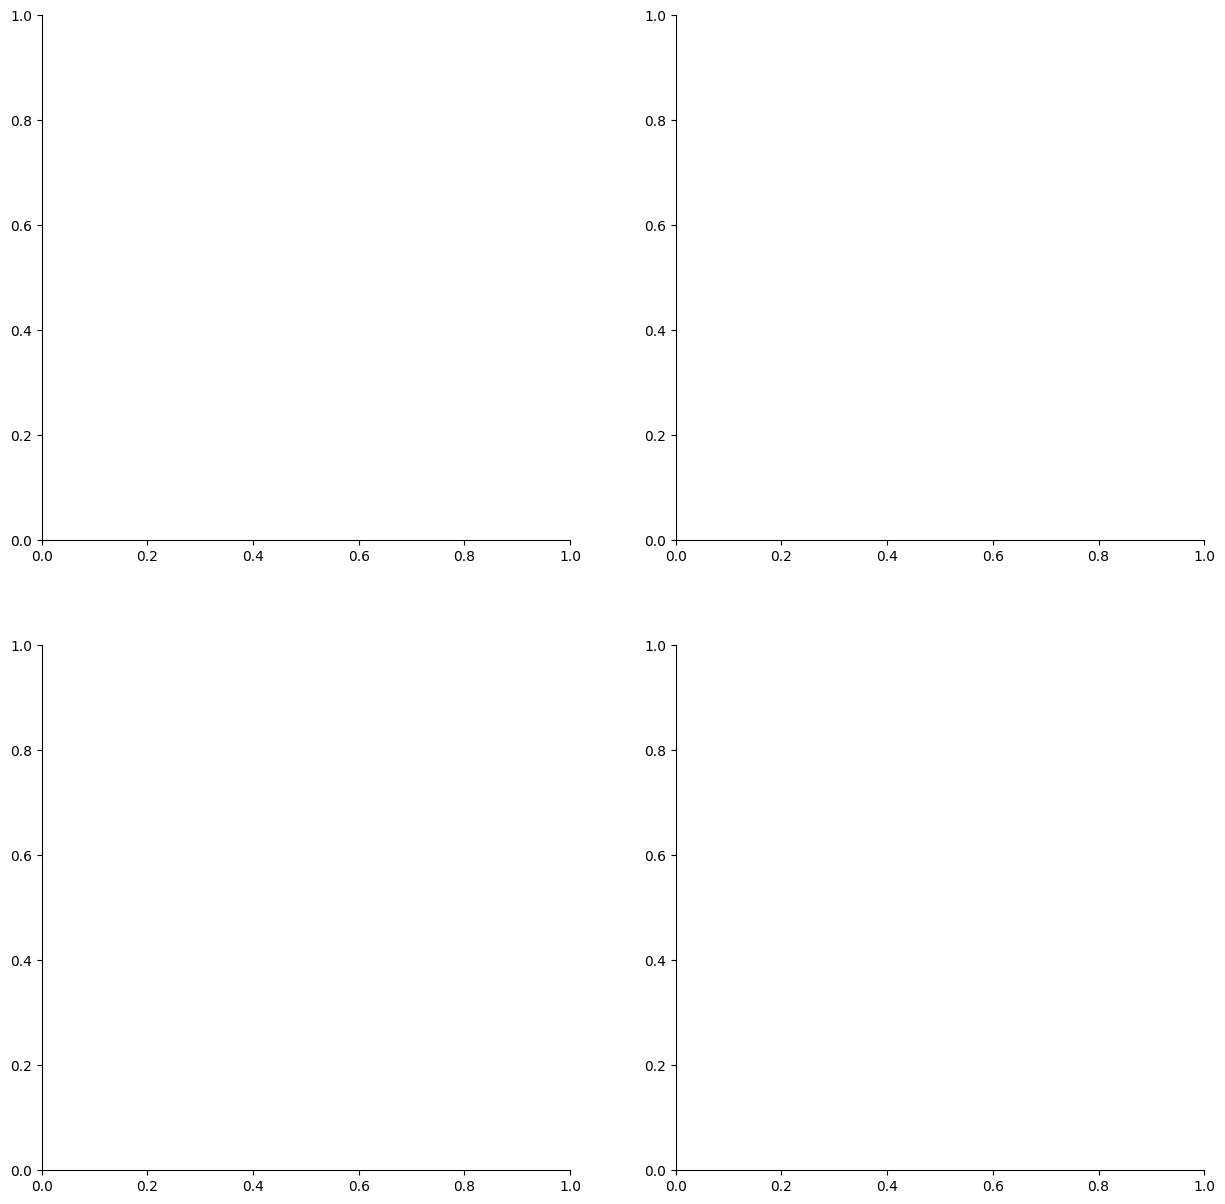

In [37]:
# import stat to can plot linear regression
import scipy.stats as stats
# have all data there
# scater plot of the perceptual similarity and activity space similarity for the best generated images and different population sizes
# exponential line space for scale the size with the population size in scatter plot
pop_size_line_space = np.exp(np.linspace(0, 2, num_of_popilation_sizes))
multiplier = 20
# define the color map
cmap = plt.cm.get_cmap('jet') 
# define the color shade for different population sizes
color_shade = np.linspace(0, 1, num_of_popilation_sizes)

metric_name_list = ["MSE", "cosine"]
similarity_metric = "alexnet"
selectoin_type_lsit = ["random", "most"]
# plot both the MSE and cosine similarity in a same figure
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
# 
i = 0
for selectoin_type in selectoin_type_lsit:
    j = 0
    sameple_title = "most active sampling" if selectoin_type == "most" else "random sampling"
    for metric_name in metric_name_list:
        # loop over all population sizes
        psi = 0
        for popsize in expriment_meta_data_df_post_hock["pop_size"].unique():
            perceptual_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)][similarity_metric]
            activity_space_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)]["score"]
            # plot the scatter plot
            # scatter plot with sircle marker and alpha = .5 size of the marker is scaled with the population size and color shade is scaled with the population size
            ax[i, j].scatter(perceptual_similarity_score_series, activity_space_similarity_score_series, marker="o", alpha=.5,
                            s=pop_size_line_space[psi]*multiplier , c=cmap(color_shade[psi]))
            psi += 1
        '''# pooling the data for linear regression
        perceptual_similarity_score_series = expriment_meta_data_df_post_hock[(
            expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
            expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
            expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)][similarity_metric]
        activity_space_similarity_score_series = expriment_meta_data_df_post_hock[(
            expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
            expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
            expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)]["score"]
        # linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(perceptual_similarity_score_series, activity_space_similarity_score_series)
        # plot the linear regression line with back color
        ax[i, j].plot(perceptual_similarity_score_series, intercept + slope*perceptual_similarity_score_series, 'k', color="black", alpha=.5)'''
            
            
        # add the legend
        ax[i, j].legend(expriment_meta_data_df_post_hock["pop_size"].unique())
        if i == 1: 
            if perceptual_similarity == 'l2_distance':
                ax[i, j].set_xlabel(f"l2 distance", fontsize=23)
            else:
                ax[i, j].set_xlabel(f"perceptual similarity \n {image_similarity_metric}", fontsize=23)
        if j == 0:
            ax[i, j].set_ylabel("activity space similarity", fontsize=23)

        ax[i, j].set_title(f"similarity metric: \n {metric_name} - {sameple_title}", fontsize=20)
        #ax[i, j].set_xlim([20, 65])
        ax[i, j].set_xlim([0,1])
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)
        if j == 0:
            ax[i, j].set_ylim([-12.5, 0])
            pass
        elif j == 1:
            pass

        j += 1
    i += 1
# save the figure
plt.savefig(os.path.join(save_root, f"{image_similarity_metric}_vs_activity_space_similarity_scatter_plot_zoom_lim.png"))

In [ ]:
# import stat to can plot linear regression
import scipy.stats as stats
# scater plot of the perceptual similarity and activity space similarity for the best generated images and different population sizes
# exponential line space for scale the size with the population size in scatter plot
pop_size_line_space = np.exp(np.linspace(0, 2, num_of_popilation_sizes))
multiplier = 20
# define the color map
cmap = plt.cm.get_cmap('jet') 
# define the color shade for different population sizes
color_shade = np.linspace(0, 1, num_of_popilation_sizes)

metric_name = "cosine"
selectoin_type = "random"
sameple_title = "most active sampling" if selectoin_type == "most" else "random sampling"
psi = 0
for popsize in expriment_meta_data_df_post_hock["pop_size"].unique():
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    perceptual_similarity_score_series = expriment_meta_data_df_post_hock[
        (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
        expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
        expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
        expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)]["l2_distance"]
    activity_space_similarity_score_series = expriment_meta_data_df_post_hock[
        (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
        expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
        expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
        expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)]["score"]
    # plot the scatter plot
    # scatter plot with sircle marker and alpha = .5 size of the marker is scaled with the population size and color shade is scaled with the population size
    ax.scatter(perceptual_similarity_score_series, activity_space_similarity_score_series, marker="o", alpha=.5,
                    s=pop_size_line_space[psi]*multiplier , c=cmap(color_shade[psi]))
    # do linear regression with cross validation

    # plot the linear regression with least absolute value regression
    # get the slope and intercept of the linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(perceptual_similarity_score_series, activity_space_similarity_score_series)

    ax.plot(perceptual_similarity_score_series, intercept + slope*perceptual_similarity_score_series, color="black", label=f"R^2 = {r_value**2:.4f}")
    psi += 1
    
    ax.legend(expriment_meta_data_df_post_hock["pop_size"].unique())
    ax.set_xlabel(similarity_metric, fontsize=15)
    ax.set_ylabel("activity space similarity", fontsize=15)
    ax.set_title(f"similarity metric: {metric_name} - {sameple_title} \n population size: {popsize}", fontsize=12)
    ax.set_xlim([20, 65])
    ax.set_ylim([.9, 1.02])
    # set tight layout
    plt.tight_layout()
    plt.legend()
    # make a new folder for save the figure
    curent_save_root = os.path.join(save_root, f"sccate_plot_{metric_name}_{selectoin_type}_for_each_pop_size")
    if not os.path.exists(curent_save_root):
        os.makedirs(curent_save_root)
    plt.savefig(os.path.join(curent_save_root, f"perceptual_similarity_vs_activity_space_similarity_scatter_plot_{metric_name}_{popsize}_{sameple_title}.png"))


In [ ]:
# get mean over re gen runs
# have all data there
# scater plot of the perceptual similarity and activity space similarity for the best generated images and different population sizes
# exponential line space for scale the size with the population size in scatter plot
pop_size_line_space = np.exp(np.linspace(0, 2, num_of_popilation_sizes))
# define the color map
cmap = plt.cm.get_cmap('jet') 
# define the color shade for different population sizes
color_shade = np.linspace(0, 1, num_of_popilation_sizes)

metric_name_list = ["MSE", "cosine"]
similarity_metric = "l2_distance"
selectoin_type = "random"
# plot both the MSE and cosine similarity in a same figure
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
# 
i = 0

for metric_name in metric_name_list:
    # loop over all population sizes
    psi = 0
    for popsize in expriment_meta_data_df_post_hock["pop_size"].unique():
        if selectoin_type == "most":
            perceptual_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)].groupby(["trget_imge_name"])["l2_distance"].mean().reset_index()["l2_distance"]
            activity_space_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)].groupby(["trget_imge_name"])["score"].mean().reset_index()["score"]
        if selectoin_type == "random":
            perceptual_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)].groupby(["trget_imge_name", "pop_resampling_id"])["l2_distance"].mean().reset_index()["l2_distance"]
            activity_space_similarity_score_series = expriment_meta_data_df_post_hock[
                (expriment_meta_data_df_post_hock["pop_size"] == popsize) & (
                expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & (
                expriment_meta_data_df_post_hock["sub_pop_type"] == selectoin_type) & (
                expriment_meta_data_df_post_hock["similarity_metric"] == metric_name)].groupby(["trget_imge_name", "pop_resampling_id"])["score"].mean().reset_index()["score"]
        # plot the scatter plot
        # scatter plot with sircle marker and alpha = .5 size of the marker is scaled with the population size and color shade is scaled with the population size
        ax[i].scatter(perceptual_similarity_score_series, activity_space_similarity_score_series, marker="o", alpha=.5,
                        s=pop_size_line_space[psi]*30 , c=cmap(color_shade[psi]))
        psi += 1
    # add the legend
    ax[i].legend(expriment_meta_data_df_post_hock["pop_size"].unique())
    ax[i].set_xlabel(similarity_metric, fontsize=15)
    ax[i].set_ylabel("activity space similarity", fontsize=15)
    ax[i].set_title(f"similarity metric: {metric_name}", fontsize=15)
    ax[i].set_xlim([20, 65])
    #if i == 0:
    #    ax[i].set_ylim([-20, 0])

    i += 1

In [ ]:
# load the dataframe that saved in the previous step
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *


data_root = r"C:\Data\cosine\insilico_experiments\Most_active_vs_random\results\real_ten_images2023-06-03_23-10"
save_root = r"C:\Data\cosine\insilico_experiments\Most_active_vs_random\results\posthock_analysis_2023-06-03_23-10"
if not os.path.exists(save_root):
    os.makedirs(save_root)
expriment_meta_data_df = pd.read_hdf(os.path.join(data_root, "expriment_meta_data_df.h5"), key="expriment_meta_data_df")
expriment_meta_data_df_post_hock = pd.read_hdf(os.path.join(save_root, "expriment_meta_data_df_post_hock.h5"), key="expriment_meta_data_df_post_hock")
expriment_meta_data_df_post_hock.head(1)

In [ ]:
# let plot the final image and activity similarity tragectory for the best generated images and different population sizes
from torchvision.transforms import ToPILImage
metric_name = "MSE"
selectoin_type = ["random", "most"]
image_name = "n09637339_1388"
# loop over all population sizes
popsize_list = [32, 64, 128, 256]
pop_resamplim_id = 4
regen_id = 2
# subplot os 4 rows and 2 columns with ratio of 1:2 for the width of the columns
fig_random, ax_random = plt.subplots(4, 2, figsize=(10, 20), gridspec_kw={'width_ratios': [1, 2]})
fig_most, ax_most = plt.subplots(4, 2, figsize=(10, 20), gridspec_kw={'width_ratios': [1, 2]})
for popsize in popsize_list:
    # load the image
    last_gen_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                    output_type="best_gen_imgs_RF_masked", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                    pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
    activity_matching_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                    output_type="popul_act_evol", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                    pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
    optimazatoin_score = column_inquary("score", expriment_meta_data_df_post_hock, 
                                    pop_size=popsize, output_type="best_gen_imgs_RF_masked", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                    pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)

    # plot the images in a row
    ax_random[popsize_list.index(popsize), 0].imshow(ToPILImage()(last_gen_image))
    ax_random[popsize_list.index(popsize), 0].set_title(f"popsize: {popsize}, \n score: {optimazatoin_score:.2f}", fontsize=20)
    ax_random[popsize_list.index(popsize), 0].axis("off")
    # plot the activity matching tragectory
    ax_random[popsize_list.index(popsize), 1].imshow(ToPILImage()(activity_matching_tragectory))
    ax_random[popsize_list.index(popsize), 1].axis("off")
    

    last_gen_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                    output_type="best_gen_imgs_RF_masked", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                    gen_rerun_id=regen_id)
    activity_matching_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                    output_type="popul_act_evol", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                    gen_rerun_id=regen_id)
    optimazatoin_score = column_inquary("score", expriment_meta_data_df_post_hock, 
                                    pop_size=popsize, output_type="best_gen_imgs_RF_masked", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                    gen_rerun_id=regen_id)

    # plot the images in a row
    ax_most[popsize_list.index(popsize), 0].imshow(ToPILImage()(last_gen_image))
    ax_most[popsize_list.index(popsize), 0].set_title(f"popsize: {popsize}, \n score: {optimazatoin_score:.2f}", fontsize=20)
    ax_most[popsize_list.index(popsize), 0].axis("off")
    # plot the activity matching tragectory
    ax_most[popsize_list.index(popsize), 1].imshow(ToPILImage()(activity_matching_tragectory))
    ax_most[popsize_list.index(popsize), 1].axis("off")
# make title for the whole figure
fig_random.suptitle(f"Random selection", fontsize=30)
fig_most.suptitle(f"Most active selection", fontsize=30)
# make new folder for saving the figures
save_folder = os.path.join(save_root, f"{metric_name}_{image_name}_best_images_and_activity_matching_tragectory")
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
# save the figures
fig_random.savefig(os.path.join(save_folder, "random_selection.png"))
fig_most.savefig(os.path.join(save_folder, "most_active_selection.png"))

In [ ]:
image_name_list = expriment_meta_data_df_post_hock["trget_imge_name"].unique().tolist()
image_name_list

In [ ]:
# let plot the final image and activity similarity tragectory for the best generated images and different population sizes
from torchvision.transforms import ToPILImage
metric_name = "cosine"
selectoin_type = ["random", "most"]
image_name_list = expriment_meta_data_df_post_hock["trget_imge_name"].unique().tolist()

# loop over all population sizes
popsize_list = [32, 64, 128, 256]
pop_resamplim_id = 1
regen_id = 3
# subplot os 4 rows and 2 columns with ratio of 1:2 for the width of the columns
for image_name in image_name_list:
    fig_, ax_ = plt.subplots(5, 6, figsize=(30, 20), gridspec_kw={'width_ratios': [1, 2, 2,1,2,2]})
    for popsize in popsize_list:
        # load the target image
        target_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="target_img_RF_masked", sub_pop_type="random", trget_imge_name=image_name,\
                                        pop_resampling_id=pop_resamplim_id)
        # load the image
        last_gen_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="best_gen_imgs_RF_masked", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
        activity_matching_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="popul_act_evol", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
        score_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="optimization_trajectory", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
        optimazatoin_score = column_inquary("score", expriment_meta_data_df_post_hock, 
                                        pop_size=popsize, output_type="best_gen_imgs_RF_masked", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)

        # plot the images in a row
        ax_[popsize_list.index(popsize)+1, 0].imshow(ToPILImage()(last_gen_image))
        ax_[popsize_list.index(popsize)+1, 0].set_title(f"popsize: {popsize}, \n score: {optimazatoin_score:.2f}", fontsize=20)
        ax_[popsize_list.index(popsize)+1, 0].axis("off")
        # plot the activity matching tragectory
        ax_[popsize_list.index(popsize)+1, 1].imshow(ToPILImage()(activity_matching_tragectory))
        ax_[popsize_list.index(popsize)+1, 1].axis("off")
        # plot the score tragectory
        ax_[popsize_list.index(popsize)+1, 2].imshow(ToPILImage()(score_tragectory))
        ax_[popsize_list.index(popsize)+1, 2].axis("off")
        

        last_gen_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="best_gen_imgs_RF_masked", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        gen_rerun_id=regen_id)
        activity_matching_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="popul_act_evol", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        gen_rerun_id=regen_id)
        score_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="optimization_trajectory", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        gen_rerun_id=regen_id)
        optimazatoin_score = column_inquary("score", expriment_meta_data_df_post_hock, 
                                        pop_size=popsize, output_type="best_gen_imgs_RF_masked", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                        gen_rerun_id=regen_id)
    

        # plot the images in a row
        ax_[popsize_list.index(popsize)+1, 3].imshow(ToPILImage()(last_gen_image))
        ax_[popsize_list.index(popsize)+1, 3].set_title(f"popsize: {popsize}, \n score: {optimazatoin_score:.2f}", fontsize=20)
        ax_[popsize_list.index(popsize)+1, 3].axis("off")
        # plot the activity matching tragectory
        ax_[popsize_list.index(popsize)+1, 4].imshow(ToPILImage()(activity_matching_tragectory))
        ax_[popsize_list.index(popsize)+1, 4].axis("off")
        # plot the score tragectory
        ax_[popsize_list.index(popsize)+1, 5].imshow(ToPILImage()(score_tragectory))
        ax_[popsize_list.index(popsize)+1, 5].axis("off")
    for i in range(6):
        ax_[0, i].axis("off")
    ax_[0,0].imshow(ToPILImage()(target_image))
    ax_[0,1].set_title(f"{metric_name} \n Random Selection", fontsize=30)
    ax_[0,3].imshow(ToPILImage()(target_image))
    ax_[0,4].set_title(f"{metric_name} \n Top Activated", fontsize=30)
    # make title for the whole figure
    # make new folder for saving the figures
    save_folder = os.path.join(save_root, f"{metric_name}_compare_sapling_selection")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    # save the figures withe tight layout
    fig_.savefig(os.path.join(save_folder, f"{image_name}.png"), bbox_inches='tight')


In [ ]:
from torchvision.transforms import ToPILImage
metric_name = "cosine"
selectoin_type = ["random", "most"]
image_name = "n09637339_1388"
# loop over all population sizes
popsize = 256
pop_resamplim_id = 1
regen_id = 3
fig_, ax_ = plt.subplots(1, 1, figsize=(5, 5))

target_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                output_type="target_img", sub_pop_type="random", trget_imge_name=image_name,\
                                pop_resampling_id=pop_resamplim_id)
# show the target image
ax_.imshow(ToPILImage()(target_image))
# past it to the thorch alexnet and get the prediction label



In [ ]:
# let cheack what'd the deal with cosine similarity
from torchvision.transforms import ToPILImage
metric_name = "cosine"
selectoin_type = ["random", "most"]
image_name = "n09637339_1388"
# loop over all population sizes
popsize = 256
pop_resamplim_id = 1
regen_id = 3
# subplot os 4 rows and 2 columns with ratio of 1:2 for the width of the columns
fig_, ax_ = plt.subplots(2, 6, figsize=(30, 7), gridspec_kw={'width_ratios': [1, 2, 2,1,2,2]})


target_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                        output_type="target_img_RF_masked", sub_pop_type="random", trget_imge_name=image_name,\
                                pop_resampling_id=pop_resamplim_id)
# load the image
last_gen_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                output_type="best_gen_imgs_RF_masked", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
activity_matching_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                output_type="popul_act_evol", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
score_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                output_type="optimization_trajectory", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)
optimazatoin_score = column_inquary("score", expriment_meta_data_df_post_hock, 
                                pop_size=popsize, output_type="best_gen_imgs_RF_masked", sub_pop_type="random", similarity_metric=metric_name, trget_imge_name=image_name,\
                                pop_resampling_id=pop_resamplim_id, gen_rerun_id=regen_id)

# plot the images in a row
ax_[1, 0].imshow(ToPILImage()(last_gen_image))
ax_[1, 0].set_title(f"popsize: {popsize}, \n score: {optimazatoin_score:.2f}", fontsize=20)
ax_[1, 0].axis("off")
# plot the activity matching tragectory
ax_[1, 1].imshow(ToPILImage()(activity_matching_tragectory))
ax_[1, 1].axis("off")
# plot the score tragectory
ax_[1, 2].imshow(ToPILImage()(score_tragectory))
ax_[1, 2].axis("off")


last_gen_image = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                output_type="best_gen_imgs_RF_masked", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                gen_rerun_id=regen_id)
activity_matching_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                output_type="popul_act_evol", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                gen_rerun_id=regen_id)
score_tragectory = load_image_tsr(expriment_meta_data_df_post_hock, data_root, pop_size=popsize,\
                                output_type="optimization_trajectory", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                gen_rerun_id=regen_id)
optimazatoin_score = column_inquary("score", expriment_meta_data_df_post_hock, 
                                pop_size=popsize, output_type="best_gen_imgs_RF_masked", sub_pop_type="most", similarity_metric=metric_name, trget_imge_name=image_name,\
                                gen_rerun_id=regen_id)


# plot the images in a row
ax_[1, 3].imshow(ToPILImage()(last_gen_image))
ax_[1, 3].set_title(f"popsize: {popsize}, \n score: {optimazatoin_score:.2f}", fontsize=20)
ax_[1, 3].axis("off")
# plot the activity matching tragectory
ax_[1, 4].imshow(ToPILImage()(activity_matching_tragectory))
ax_[1, 4].axis("off")
# plot the score tragectory
ax_[1, 5].imshow(ToPILImage()(score_tragectory))
ax_[1, 5].axis("off")
for i in range(6):
        ax_[0, i].axis("off")
ax_[0,0].imshow(ToPILImage()(target_image))
ax_[0,1].set_title(f"{metric_name} \n Random Selection", fontsize=30)
ax_[0,3].imshow(ToPILImage()(target_image))
ax_[0,4].set_title(f"{metric_name} \n Top Activated", fontsize=30)

In [ ]:
# tiny reconstruction module here to ass the problem of cosine
# Importing libraries 
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
import wget
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\image_net_tiny"

net_name = "alexnet"
layer_name = ".features.Conv2d10"
layer_short = "conv5"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (187, 187)
pading_size = (20, 20) 
popsize = 256
score_method = "cosine"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
for imgid in range(len(refimgnms)):
    targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]

    # show target image
    plt.imshow(ToPILImage()(target_imgtsr[0]))
    plt.axis("off")
    plt.show()

    scorer = TorchScorer(net_name)
    module_names, module_types, module_spec = get_module_names(
            scorer.model, input_size, "cuda", False)
    scorer.model.eval()
    # Make predictions
    with torch.no_grad():
        output = scorer.model(target_imgtsr.to(torch.device('cuda:0'))).cpu().detach()

    # Load the class labels for ImageNet
    #class_name_path = wget.download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", out=refimgdir)
    #print(class_name_path)
    class_name_path = os.path.join(refimgdir,'imagenet_classes.txt')
    with open(class_name_path) as f:
        classes = [line.strip() for line in f.readlines()]

    # Get the predicted class labels
    n = 3
    _, predicted_indices = torch.topk(output, k=n)
    predicted_labels = [classes[idx] for idx in predicted_indices.squeeze()]

    print(f"Top {n} predicted class labele for image {imgid}:")
    for label in predicted_labels:
        print(label)


In [ ]:
# finde any class name that contain "men"
name = "gorilla"
face_class = [i for i in classes if name in i]
# print the class name and the index
for i in range(len(face_class)):
    print(f" class name: {face_class[i]}, index: {classes.index(face_class[i])} \n")


In [ ]:
target_imgtsr.shape

In [ ]:
# tiny reconstruction module here to ass the problem of cosine
# Importing libraries 
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\image_net_tiny"

net_name = "alexnet"
layer_name = ".features.Conv2d10"
layer_short = "conv5"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (187, 187)
pading_size = (20, 20) 
popsize = 256
score_method = "cosine"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
imgid = 4
targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
                    scorer_random, [layer_name], popsize=popsize, seed=pop_resampling_id)
fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)
targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
targlabel = os.path.splitext(targnm)[0]

target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
plt.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
plt.axis("off")
plt.show()

title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=expriment_meta_data_df, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

plt.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
plt.axis("off")
plt.show()
figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()

In [ ]:
last_gem_img_maske.mean(dim=0).shape
plt.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))

In [ ]:
# tiny reconstruction module here to ass the problem of cosine
# Importing libraries 
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.CNN_scorers import TorchScorer
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\data\data_sample"
imgtsr = torch.stack([last_gen_image, target_image])
net_name = "alexnet"
scorer = TorchScorer(net_name)
model_output = scorer.model(imgtsr.to(torch.device('cuda:0'))).cpu().detach()



In [ ]:

torch.corrcoef(model_output)[0, 1]